# A tour of Machine Learning Clasifiers Using scikit-learn
En este capitulo se revisara una coleccion popular de algoritmos de machine learning. Interactuaremos por primera vez con la biblioteca **sickit-learn** y veremos algunos algoritmos de aprendizaje supervisado para clasificacion. 

### Como elegir un algortimo de clasificacion
Elegir un algoritmos de clasificacion para un problema en particular requiere practica y experiencia. Cada algoritmos tiene sus pros y sus contra asi como cada uno esta basado en diferentes hipotesis sobre los datos.

Los diferentes algoritmos pueden varias en cantidad e features necesarias, ruido en el dataset, si las clases a a clasificar son linealmente separables etc. En general, los principales pasos que estan involucrados en entrenar un algoritmo supervisado de ML son:

1. Seleccionar las features y recolectar ejemplos para el entrenamiento
2. Elegir una metrica de perfomance
3. Elegir un algoritmos y entrenar el modelo
4. Evaluar la perfomance del modelo
5. Cambiar la configuracion para mejorar el modelo

##  First steps with scikit-learn – training a perceptron

Vamos a hacer algo parecido a lo que hicimos el capitulo anterior y vamos entrenar un perceptron. Pero esta vez en lugar de armarlo desde 0 utilizando Numpy vamos a utilizar la biblioteca de scikit-learn.

In [47]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [48]:
#Para poder ver que tan bien funciona el modelo vamos a separar el dataset en train test,
#una metodolgia que se vera con mas profundidad en el capitulo 6

from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.3, random_state= 1, stratify= y #Este parametro asegura la misma proporcion de labes en ambos datasets
)   

In [49]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Muchos algoritmos de ML siguen ciertas hipotesis acerca de sus datos para poder funcionar de manera correcta, es este caso estandarizaremos los datos utilizando el **StandarScaler** de scikit lear.


In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

Una vez estandarizados nuestros datos vamos a importar el perceptron y entrenarlo con nuestros datos. Por default muchos modelos de SK vienen con el tipo de clasificacion conocido como **one-versus-rest**

In [51]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.01, random_state=1)
ppn.fit(X_train_sc,y_train)

Perceptron(eta0=0.01, random_state=1)

In [52]:
y_pred = ppn.predict(X_test_sc)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 2


In [53]:
#Existen otras metricas que uno podria revisar de un modelo, como la accuracy.
from sklearn.metrics import accuracy_score
print("Accuracy: %.3f"% accuracy_score(y_test,y_pred))

Accuracy: 0.956


In [54]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
 # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
 # highlight test examples
    if test_idx:
 # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

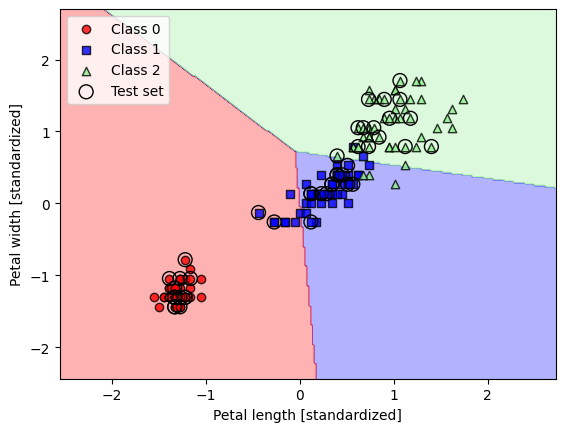

In [55]:
X_combined_std = np.vstack((X_train_sc, X_test_sc))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                       y=y_combined,
                       classifier=ppn,
                       test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')


## Modeling class probabilites via logistic regression
Si bien la regla del percepron es un buen algoritmo introductorio para clasificacion. En realidad no es tan poderoso debido a que si las clases no son linealmente separables el algoritmo nunca va a converger.
En esta seccion veremos el algortimos de **regresion logistica** para clasificacion.

### Logistic regression and conditional probabilities.
Es un modelo de para clasificacin binaria. Funciona mediante el uso de **probabilidad condicional**.
Lo que buscamos es relacinar la funcion *logit* que esta definida como
$$
logit(p)= \frac{p}{(1-p)}
$$
de manera lineal con las features pesadas de la manera
$$
logit(p) = \sum_{i=j}w_{j}x_{j}+b
$$

Mientras que la funcion logit mapea las probabilidades a todo el rango de los numeros reales, nos gustaria tener la inversa. La cual mapea cualquiera numero real al rango de probabilidades entre [0,1]. La inversa es conocida como **funcion sigmoide**
$$
\sigma (z) = \frac{1}{z+e^{-z}}
$$
Donde $z$ es el input neto de la combinacion lineal de los pesos y los inputs.
$$
z = w^{T} x + b
$$

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ivanl\AppData\Local\Temp\ipykernel_13648\108725810.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma (z)')


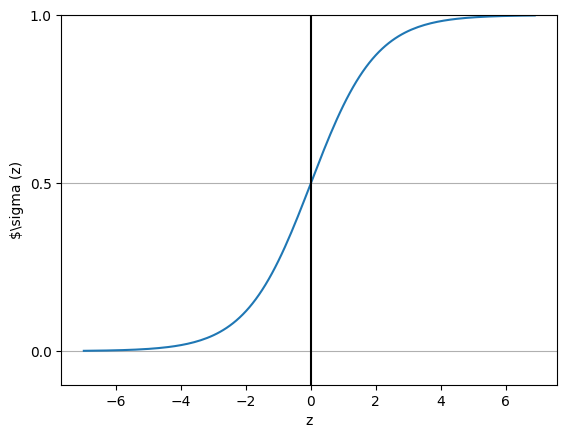

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
z = np.arange(-7,7,0.1)
sigma_z = sigmoid(z)
plt.plot(z,sigma_z)
plt.axvline(0.0,color= 'k')
plt.ylim(-0.1,0.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)')
plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout
plt.show()

El ouput de la sigmoide se interpreta como la probabilidad de un ejemplo en particular de pertencer a una cierta clase, es decir
$$
\sigma (z) = p(y = 1|x;w;b)
$$
luego utiliznado la funcion de corte se convierte esta probabilidad en un output binario.


### Learning the model weigths via the logistic loss function
Al igual que vimos anteriormente la funcion de perdida MSE, queremos definir una funcion de perdida para la regresion logistica la cual optimizar para obtener los parametros $w$ y $b$ ideales. En el caso de la regresion logistica vamos a buscar **maximizar la likelihood**. La cual, en el caso de que todos los ejemplos en el dataset sean independientes entre si, se escribe como:
$$
L(w,b|x) = p(y|x;w,b) = \prod_{i}^{n} p(y^{i}|x^{i};w,b) = \prod (\sigma (z^{i}))^{y^{i}} (1-\sigma (z^{i}))^{1-y^{i}}
$$
En su lugar vamos a maximizar el logartimos de esta ecuacion ,ya que es mas sencillo
$$
l(w,b|x) = log(L) = \sum_{i} v
$$
Esta funcion es una que se debe **maximiza** pero es posible reescribiarla de forma que sea minimizable y aplicarle el descenso de gradiente como venimos haciendo.
$$
L(w,b) = \sum_{i}^{n} [- y^{i}\log (\sigma (z^{i}))- (1-y^{i}) \log (1- \sigma (z^{i}))]
$$
Esto puede verse como dos fuciones distintas, que forman una.

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ivanl\AppData\Local\Temp\ipykernel_13648\2806226088.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(z)$')


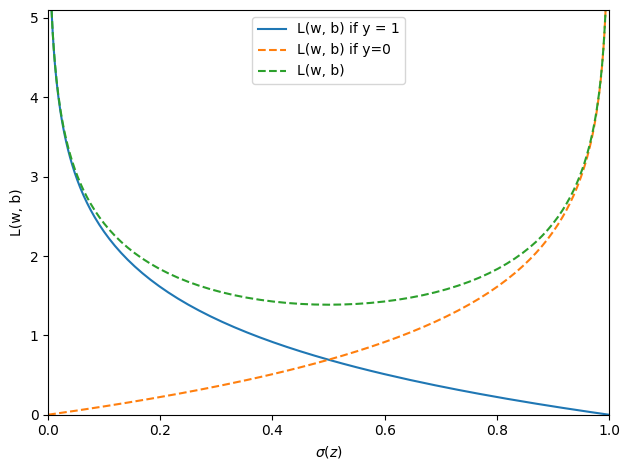

In [62]:
def loss_1(z):
    return - np.log(sigmoid(z))
def loss_0(z):
    return - np.log(1-sigmoid(z))
z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label= 'L(w, b) if y = 1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
plt.plot(sigma_z, np.array(c1) + np.array(c0) , linestyle='--', label='L(w, b)')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Converting an Adaline implementation into an algorithm for logistic regression.
